In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import IPython
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from torch import nn,optim,Tensor
import torch
from tqdm import tqdm
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import r2_score

### 需求：
* 先对数据做线性回归，
* 计算并定义残差+常数项，
* 通过基于人工鱼群算法改进的LSTM神经网络对定义的这项进行非线性拟合，再进行预测

In [2]:
root=r"D:\Business\LSTM_NN\data\raw_data.csv"
data = pd.read_csv(root)
train_data=data[:730]#before 2021.12.31


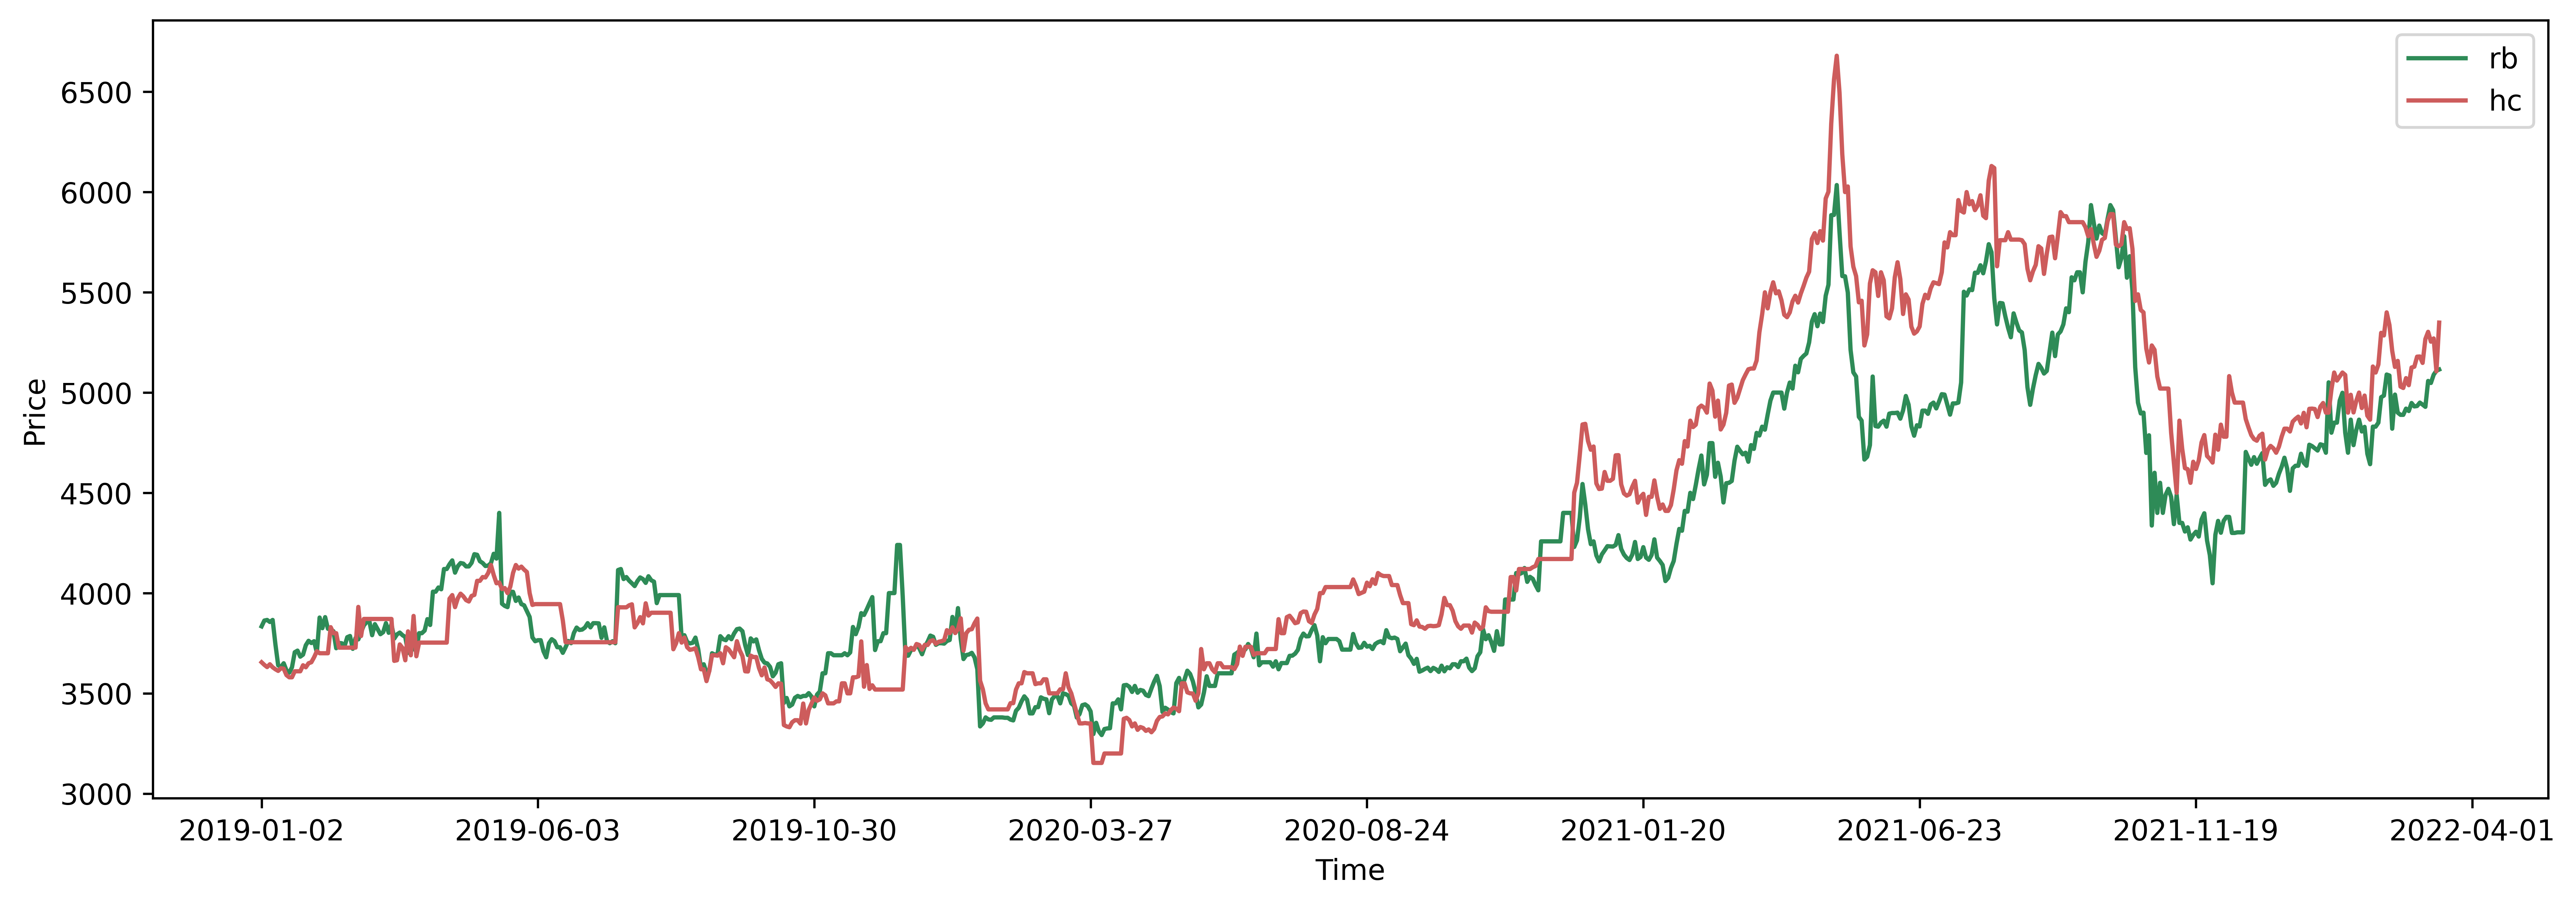

In [6]:
rb_arr,hc_arr=np.array(data['rb']),np.array(data['hc'])
# date1 = datetime.date(2019,1,1)
# date2 = datetime.date(2022,12,31)
# delta = datetime.timedelta(days = 2)
# dates = mdates.drange(date1, date2, delta)
plt.rcParams['figure.figsize'] = [15,5]
mpl.rcParams['figure.dpi']=600
plt.plot(np.arange(len(rb_arr)),rb_arr,color='seagreen',label='rb')
plt.plot(np.arange(len(rb_arr)),hc_arr,color='indianred',label='hc')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks([0,100,200,300,400,500,600,700,800],['2019-01-02','2019-06-03','2019-10-30','2020-03-27','2020-08-24','2021-01-20','2021-06-23','2021-11-19','2022-04-01'])
plt.legend()


len(X_train):730


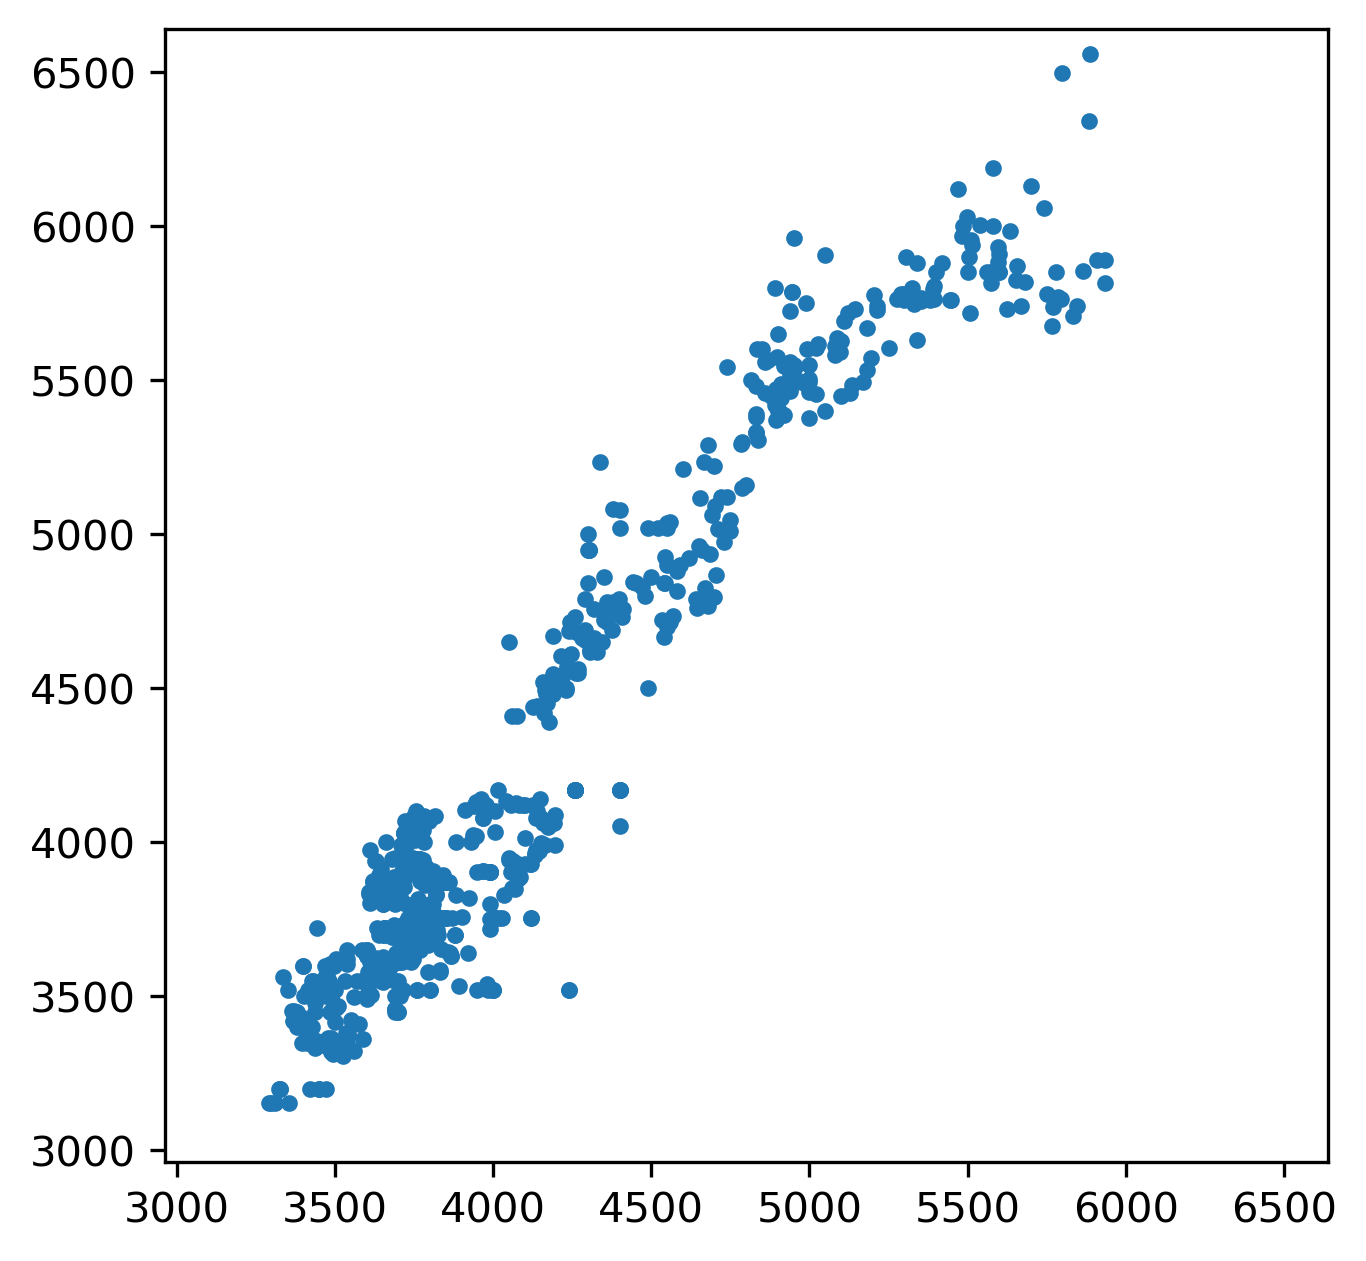

In [12]:
plt.rcParams['figure.figsize'] = [5,5]
mpl.rcParams['figure.dpi']=300
max_v = max(train_data['rb'].max(),train_data['rb'].max()) * 1.1
min_v = min(train_data['rb'].min(),train_data['rb'].min()) * 0.9
plt.plot(train_data['rb'],train_data['hc'],'.')
plt.xlim(min_v,max_v)
plt.ylim(min_v,max_v)
#DataFrame-->Numpy
X_train=np.array(train_data['rb'])
y_train=np.array(train_data['hc'])
print('len(X_train):{}'.format(len(X_train)))

In [6]:
# #数据集划分
# #from sklearn.cross_validation import train_test_split # 适用低版本
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, 
#     y,
#     test_size=0.2,
#     random_state=33)
# print("X_train.shape = {0}   X_test .shape = {1}\ny_train.shape = {2}   y_test .shape = {3}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

In [7]:
#数据标准化
from sklearn.preprocessing import StandardScaler
# 转换为二维数组，冗余，但不得不做
X_train = X_train.reshape(-1,1) # 1 列
y_train = y_train.reshape(-1,1) # 1 列

# 拟合
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
# 对 X_train、y_train 标准化
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)

# 转为一维数组
y_train = y_train.reshape(-1,)

In [8]:
#评价
#r2_score 评价方法
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
def train_and_evaluate(regr, X_train, y_train):
    regr.fit(X_train, y_train)  # 训练

    print ("在训练集上，决定系数：", regr.score(X_train, y_train))

    # 创建 K-折
    cv = KFold(5, shuffle=True, random_state=33)                     # model_selection 模块用
    #cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)  # cross_validation 模块用

    scores = cross_val_score(regr, X_train, y_train, cv=cv)
    print ("使用 K-折交叉验证的 平均决定系数:",np.mean(scores))

In [9]:
from sklearn import linear_model
regr_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None, max_iter=5, tol=None, random_state=42)
train_and_evaluate(regr_sgd, X_train, y_train)

在训练集上，决定系数： 0.9272206052692623
使用 K-折交叉验证的 平均决定系数: 0.9266037749892349


C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed i

In [14]:
#可视化
mpl.rcParams['figure.dpi']=300
plt.rcParams['figure.figsize'] = [5,5]
def visualization_for_predict_data(data_observed, data_predicted, label_observed, label_predicted):
    plt.scatter(data_observed, data_predicted)

    max_v = np.max([data_predicted] + [data_observed]) * 1.1
    min_v = np.min([data_predicted] + [data_observed]) * 1.1

    plt.plot([min_v,max_v], [min_v,max_v], "r-")

    plt.xlabel(label_observed)
    plt.ylabel(label_predicted)

y_pred = regr_sgd.predict(X_train)
# y_pred=y_pred.reshape(-1,1)
visualization_for_predict_data(y_train, y_pred, "y_train", "y_pred")

ValueError: Expected 2D array, got 1D array instead:
array=[3834 3863 3866 3856 3866 3745 3640 3631 3650 3615 3603 3630 3705 3713
 3683 3693 3740 3762 3751 3760 3703 3878 3825 3880 3822 3818 3810 3725
 3751 3750 3734 3780 3786 3722 3776 3769 3805 3839 3855 3860 3790 3845
 3820 3795 3805 3850 3802 3845 3773 3794 3803 3790 3781 3702 3718 3720
 3715 3800 3800 3813 3870 3841 4007 4007 4028 4019 4120 4120 4144 4163
 4102 4134 4150 4147 4133 4133 4151 4194 4191 4159 4150 4135 4137 4149
 4196 4172 4400 3947 3936 3930 4007 4006 3961 3978 3945 3939 3910 3881
 3779 3760 3765 3765 3710 3680 3750 3770 3760 3730 3730 3702 3730 3761
 3750 3801 3828 3816 3818 3828 3850 3829 3850 3850 3849 3777 3829 3760
 3750 3760 3750 4115 4120 4070 4080 4062 4049 4035 4060 4078 4070 4051
 4084 4064 4057 3950 3990 3990 3990 3990 3990 3990 3990 3990 3776 3790
 3756 3749 3752 3778 3720 3626 3645 3604 3612 3700 3693 3696 3785 3770
 3765 3785 3770 3799 3820 3823 3810 3741 3691 3774 3759 3769 3715 3672
 3653 3649 3632 3585 3603 3645 3650 3452 3477 3435 3444 3478 3487 3481
 3487 3487 3501 3484 3435 3494 3509 3600 3600 3700 3700 3690 3690 3690
 3690 3700 3690 3704 3831 3795 3831 3900 3891 3919 3950 3980 3716 3760
 3760 3800 3800 4000 4000 4000 4240 4240 3985 3687 3688 3716 3719 3741
 3725 3695 3734 3757 3788 3782 3742 3750 3750 3748 3761 3766 3881 3801
 3925 3770 3671 3691 3694 3702 3679 3620 3335 3350 3380 3370 3368 3380
 3380 3380 3380 3378 3378 3369 3365 3413 3428 3460 3485 3468 3400 3400
 3431 3431 3480 3473 3470 3401 3470 3486 3486 3450 3500 3496 3488 3450
 3438 3379 3397 3441 3445 3435 3410 3297 3353 3310 3292 3322 3325 3326
 3450 3450 3470 3420 3540 3542 3533 3507 3537 3503 3517 3513 3492 3486
 3524 3559 3587 3536 3407 3428 3419 3406 3400 3551 3577 3530 3570 3613
 3597 3560 3504 3430 3444 3504 3585 3537 3537 3537 3600 3600 3600 3600
 3600 3600 3693 3702 3714 3712 3719 3746 3725 3680 3798 3640 3655 3655
 3655 3655 3633 3660 3620 3651 3651 3651 3687 3688 3698 3717 3773 3798
 3784 3785 3816 3840 3789 3660 3780 3750 3771 3771 3771 3771 3760 3718
 3718 3718 3718 3796 3750 3727 3729 3752 3733 3737 3721 3746 3755 3760
 3750 3815 3780 3775 3778 3771 3710 3729 3748 3690 3673 3647 3672 3608
 3614 3622 3628 3611 3627 3620 3607 3638 3610 3630 3625 3645 3645 3631
 3660 3660 3673 3628 3611 3625 3685 3705 3820 3770 3790 3756 3712 3810
 3744 3744 3968 3968 3968 3968 4100 4094 4100 4125 4056 4081 4071 4040
 4014 4258 4258 4258 4258 4258 4258 4258 4258 4400 4400 4400 4400 4230
 4263 4376 4544 4442 4318 4244 4258 4188 4158 4193 4213 4234 4233 4232
 4240 4289 4220 4192 4175 4165 4192 4255 4170 4180 4229 4177 4166 4190
 4268 4177 4160 4140 4060 4076 4125 4160 4245 4320 4311 4410 4406 4500
 4469 4540 4618 4686 4542 4590 4748 4748 4580 4650 4581 4452 4548 4550
 4559 4660 4730 4710 4692 4700 4655 4738 4719 4799 4786 4830 4815 4890
 4960 5000 5000 5000 5000 4920 5000 5050 5020 5134 5101 5168 5183 5195
 5250 5354 5391 5331 5394 5352 5483 5538 5885 5886 6035 5800 5581 5580
 5499 5213 5101 5080 4879 4860 4666 4680 4738 5080 4833 4830 4850 4860
 4830 4895 4898 4898 4900 4870 4911 4983 4940 4832 4785 4837 4831 4910
 4910 4894 4940 4950 4921 4955 4992 4990 4940 4890 4946 4946 4950 5050
 5503 5484 5515 5511 5598 5597 5635 5595 5655 5740 5700 5470 5340 5447
 5445 5380 5323 5276 5395 5350 5310 5300 5212 5027 4939 5020 5087 5143
 5123 5095 5108 5203 5299 5182 5290 5305 5340 5420 5401 5575 5560 5600
 5600 5500 5652 5750 5935 5846 5768 5833 5795 5786 5866 5935 5910 5770
 5625 5670 5780 5573 5680 5507 5127 4950 4896 4900 4699 4787 4337 4600
 4400 4550 4400 4490 4520 4480 4344 4490 4350 4350 4307 4328 4267 4290
 4306 4282 4367 4398 4262 4190 4049 4290 4360 4301 4360 4380 4380 4300
 4300 4303 4303 4303 4704 4671 4640 4678 4645 4673 4698 4540 4559 4567
 4535 4550].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [15]:
print("after standard:regr_sgd.coef_ = {}\n".format(regr_sgd.coef_))
print("after standard:regr_sgd.intercept_ = {}\n".format(regr_sgd.intercept_))
sigma_x=train_data['rb'].std()
sigma_y=train_data['hc'].std()
mean_x=train_data['rb'].mean()
mean_y=train_data['hc'].mean()
coef=regr_sgd.coef_*(sigma_y/sigma_x)
intercept=(regr_sgd.intercept_*sigma_y)-(coef*mean_x-mean_y)
print("raw coef_ = {}\n".format(coef))
print("raw intercept_ = {}\n".format(intercept))

after standard:regr_sgd.coef_ = [0.96383293]

after standard:regr_sgd.intercept_ = [0.00150169]

raw coef_ = [1.23405026]

raw intercept_ = [-829.12180592]



Text(0, 0.5, 'HC')

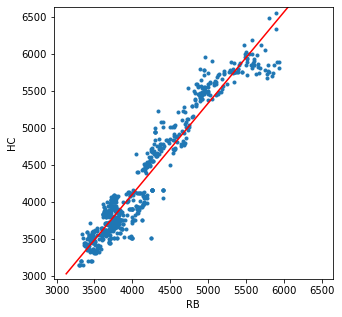

In [12]:
plt.rcParams['figure.figsize'] = [5,5]
max_v = max(train_data['rb'].max(),train_data['rb'].max()) * 1.1
min_v = min(train_data['rb'].min(),train_data['rb'].min()) * 0.9
max_l = max(train_data['rb'].max(),train_data['rb'].max()) * 1.05
min_l = min(train_data['rb'].min(),train_data['rb'].min()) * 0.95
plt.plot(train_data['rb'],train_data['hc'],'.')
plt.plot((min_l,max_l), (coef*min_l+intercept,coef*max_l+intercept),"r-")
plt.xlim(min_v,max_v)
plt.ylim(min_v,max_v)
plt.xlabel('RB')
plt.ylabel('HC')

Beta=[0.81033977]



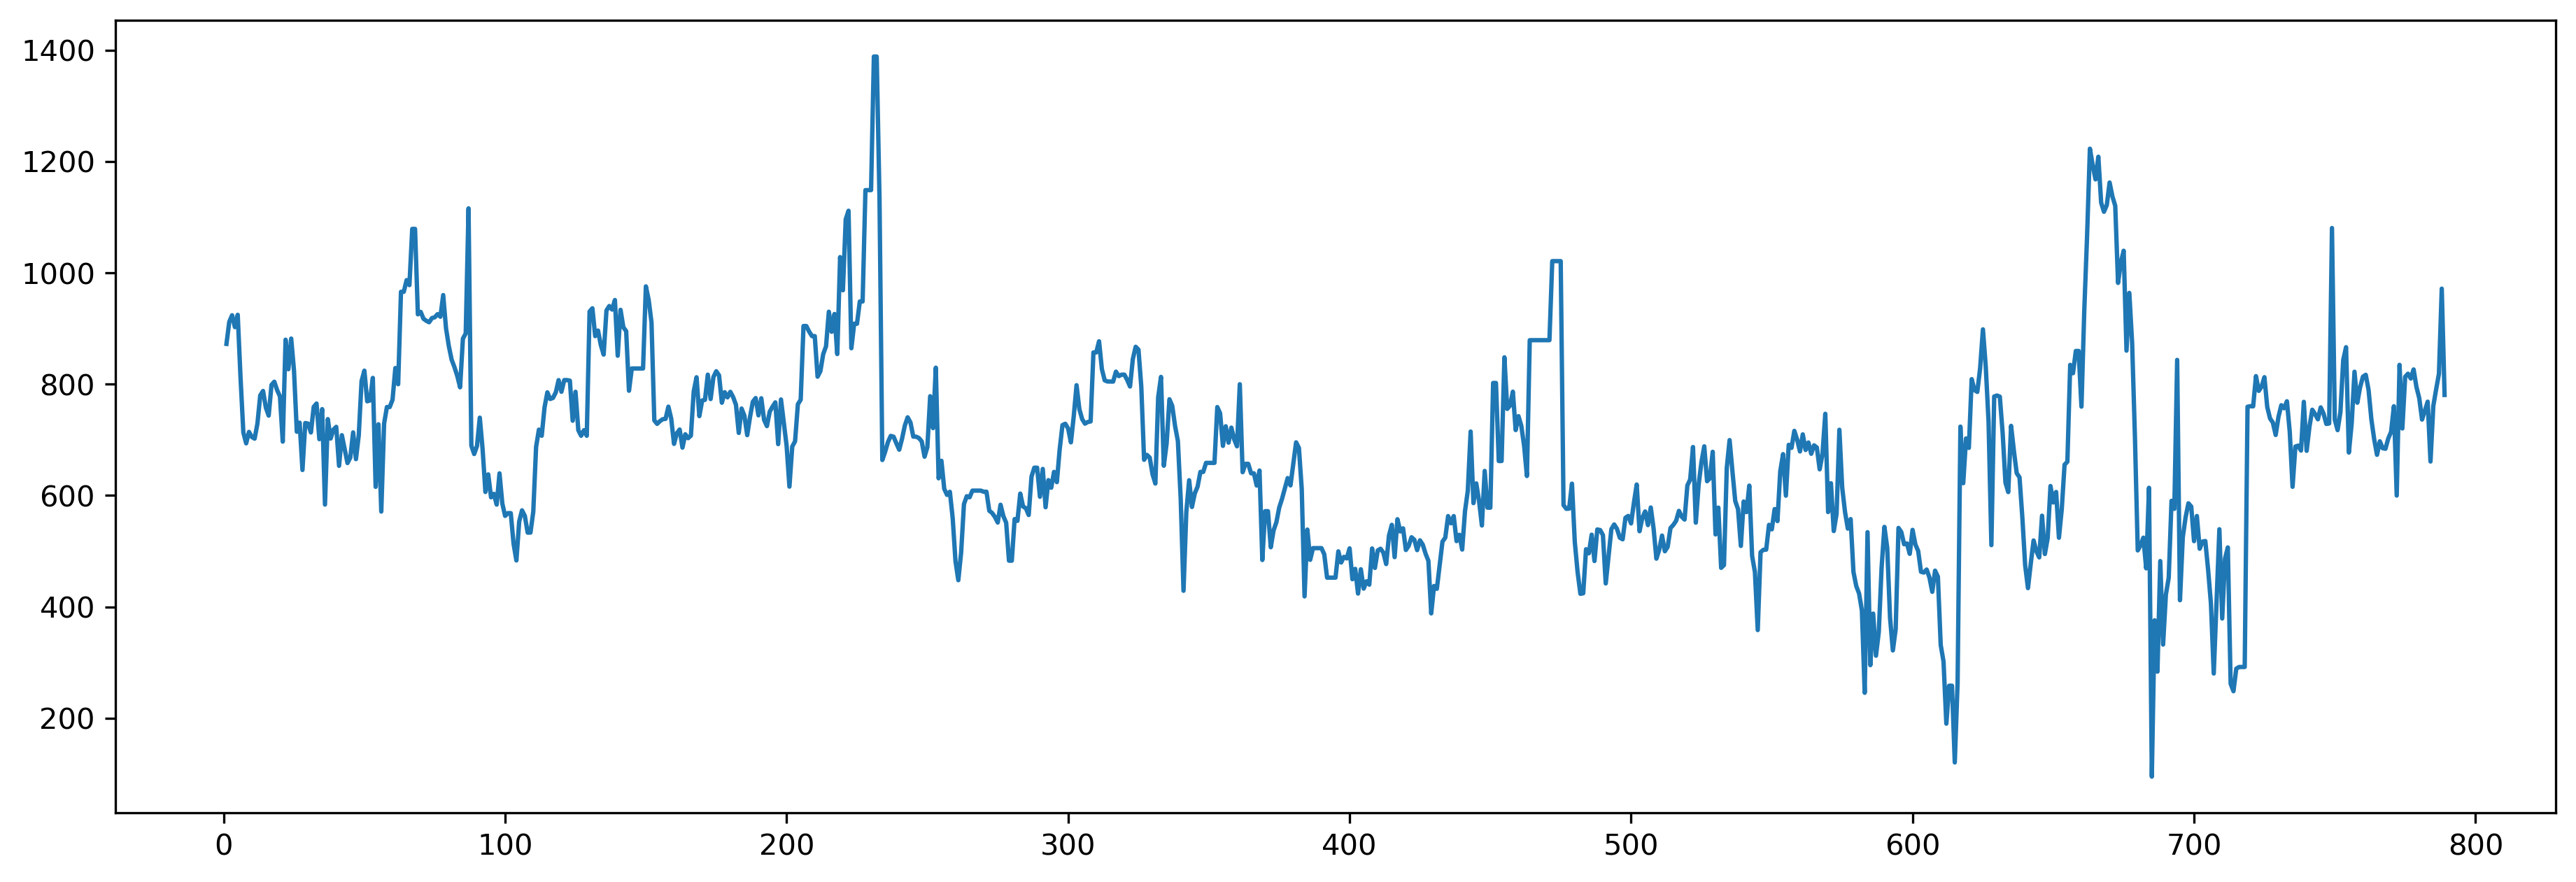

In [33]:
Beta=1/coef
print("Beta={}\n".format(Beta))
Spread=data['rb']-Beta*data['hc']
time=np.linspace(1,789,789)
time1=np.linspace(1,730,730)
time2=np.linspace(730,789,59)
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(time,Spread,'-')

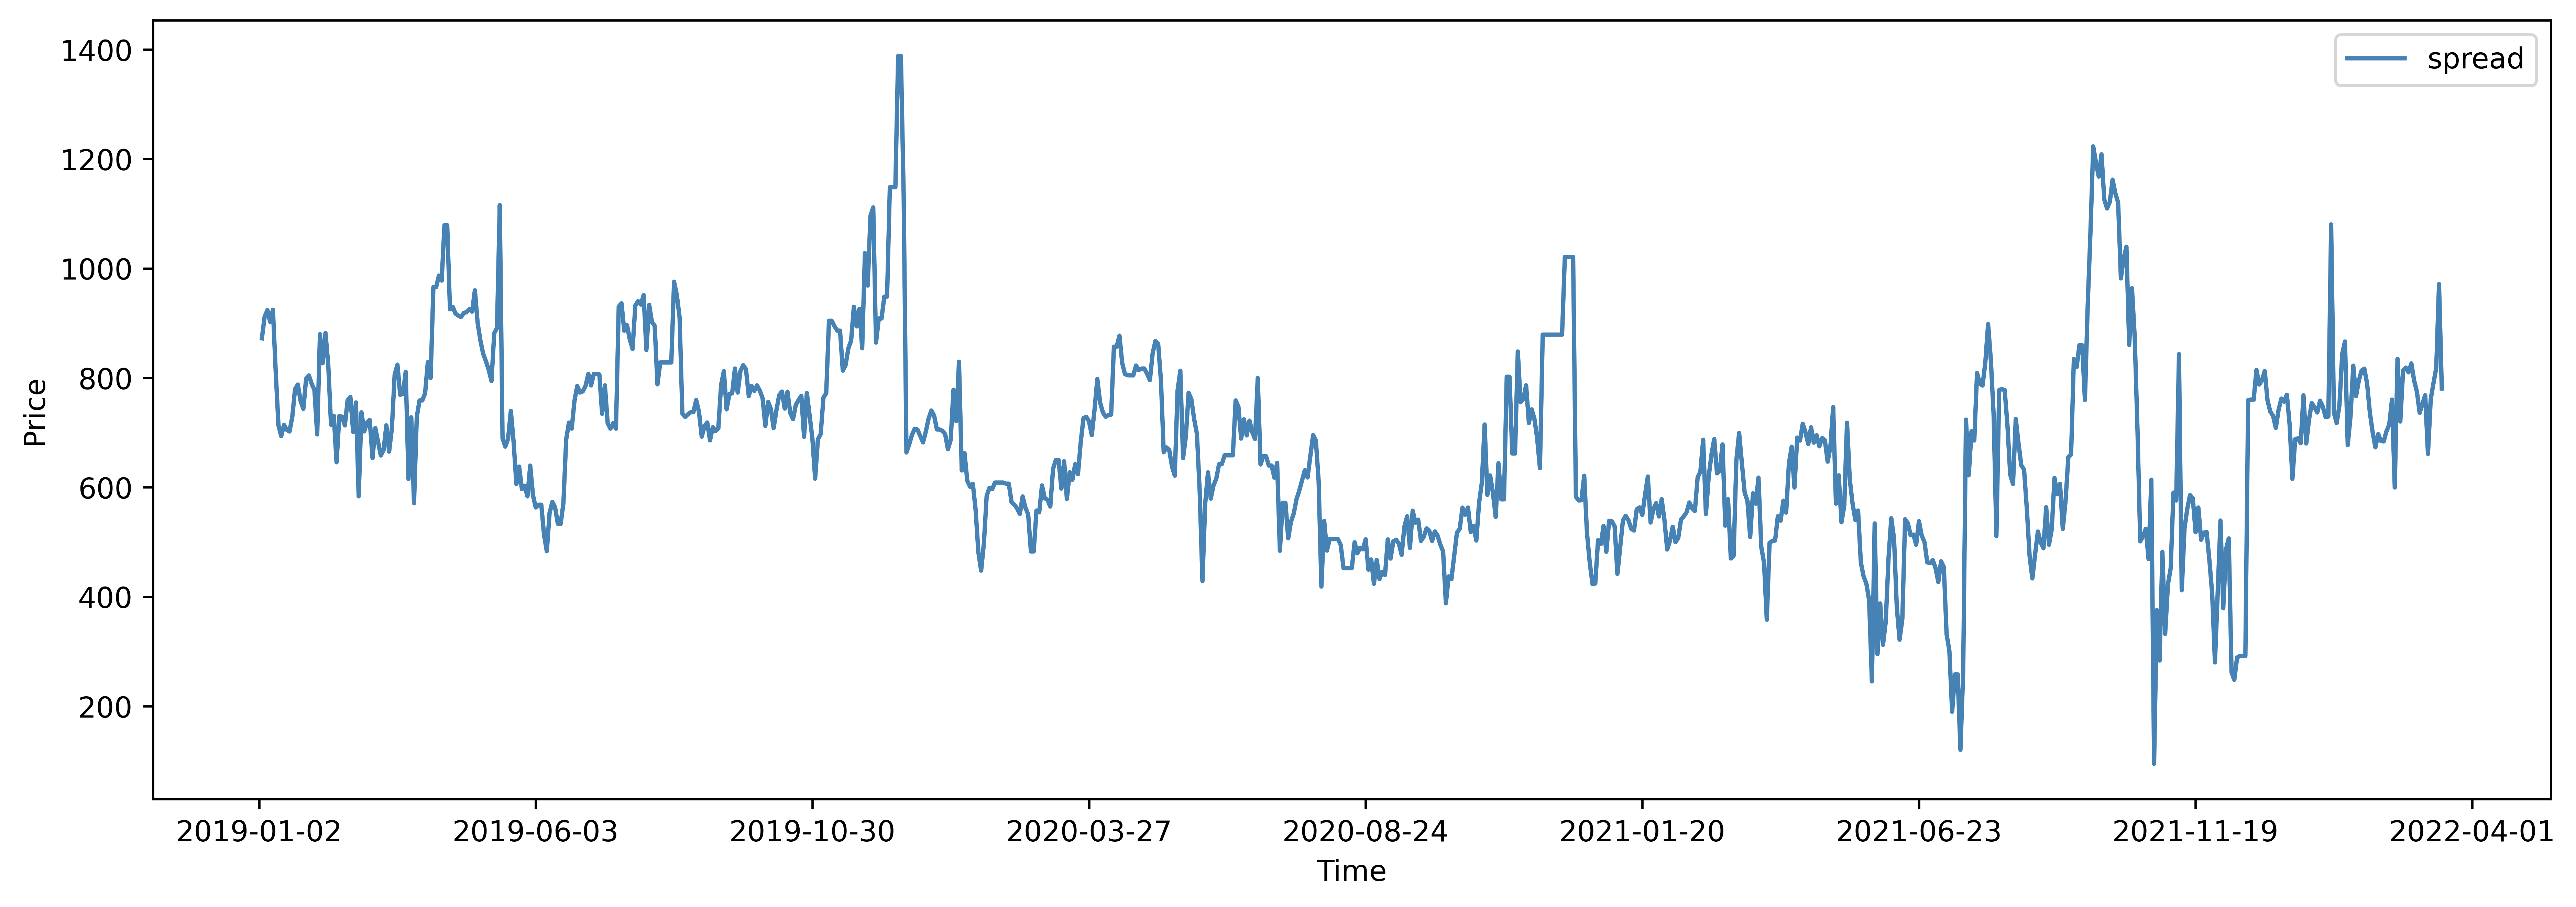

In [34]:

mpl.rcParams['figure.dpi']=600
plt.plot(time,Spread,color='steelblue',label='spread')
# plt.plot(np.arange(len(rb_arr)),hc_arr,color='indianred',label='hc')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks([0,100,200,300,400,500,600,700,800],['2019-01-02','2019-06-03','2019-10-30','2020-03-27','2020-08-24','2021-01-20','2021-06-23','2021-11-19','2022-04-01'])

plt.legend()

In [35]:
Spread_arr=np.array(Spread)
Spread_2D=Spread_arr.reshape(-1,1)
scaler = StandardScaler().fit(Spread_2D[:740])
Spread_new=scaler.transform(Spread_2D)


In [31]:
predict_intake_len=10
from torch.utils.data import Dataset,DataLoader
class Time_Series_Data(Dataset):
    def __init__(self, data):
        self.data = data
#         self.scaler = StandardScaler().fit(data)
#         self.std_data = self.scaler.transform(data)

    def __getitem__(self, idx):
        
        x_t = torch.tensor(self.data [idx:idx+predict_intake_len]).reshape(-1,1).float()
        y_t = torch.tensor(self.data [idx+predict_intake_len]).float()
        return x_t, y_t

    def __len__(self):
        return len(self.data)-predict_intake_len

### 创建 LSTM 层

In [23]:
class LSTM(nn.Module):
    def __init__(self,
                 input_size = 1,
                 hidden_size = 10,
                 num_layers =2,
                 batch_first = True,
                 dropout =0.3):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size,  
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=batch_first,
            dropout = dropout)
        
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*predict_intake_len, 1))
        
    def forward(self, x,h,c):
        r_out, (h,c) = self.lstm(x, (h,c)) 
        out = self.fc(r_out.flatten())
        return out, (h,c)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [65]:
def train_loop(dataloader, model, loss_fn, optimizer,scheduler,device):
    h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    loss_total =  0
    optimizer.zero_grad()
    outs = []
    truths = []
    for batch_idx, (X,y) in enumerate(dataloader):  
        X,y = X.to(device),y.to(device)
        out,(h,c) = model(X,h,c)
        loss_total+=loss_fn(out, y)
        outs.append(out.to('cpu').item())
        truths.append(y.to('cpu').item())
    # Backpropagation
    loss_total.backward()
    optimizer.step()
    scheduler.step()
    print(f"Train loss: {loss_total.item():>7f}")
    return outs,truths
def test_loop(dataloader, model, loss_fn, device):
    h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    loss_total =  0
    with torch.no_grad():
        for batch_idx, (X,y) in enumerate(dataloader):  
            X,y = X.to(device),y.to(device)
            out,(h,c) = model(X,h,c)
            loss_total+=loss_fn(out, y)
        print(f"Test loss: {loss_total.item():>7f}")
def predict(dataloader,model,device):
    h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    outs,ys = [],[]
    with torch.no_grad():
        for batch_idx, (X,y) in enumerate(dataloader):  
            X,y = X.to(device),y.to(device)
            out,(h,c) = model(X,h,c)
            outs.append(out.to('cpu'))
            ys.append(y.to('cpu'))
        plt.plot(np.arange(len(ys)),outs,label = 'predict')
        plt.plot(np.arange(len(ys)),ys,label = 'ground truth')
        plt.legend()


In [61]:
def run(device,train_dataloader,test_dataloader,model,loss_fn,optimizer,scheduler,epochs):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        outs,truths = train_loop(train_dataloader, model, loss_fn, optimizer,scheduler,device)
        test_loop(test_dataloader, model, loss_fn,device)
    predict(test_dataloader, model,device)

In [66]:
learning_rate = 0.05
scheduler_step_size = 50
scheduler_gamma = 0.5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataloader = Time_Series_Data(Spread_new[:730])
test_dataloader  = Time_Series_Data(Spread_new[730:])

model = LSTM(input_size = 1,
             hidden_size = 10,
             num_layers =4,
             batch_first = True,
             dropout =0.3).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

run(epochs = 200,
    device = device,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    model = model,
    loss_fn = loss_fn,
    optimizer = optimizer,
    scheduler = scheduler,
)
torch.save(model,'model_LSTM1')

Epoch 1
-------------------------------
Train loss: 736.917786
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(

Train loss: 724.058228
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, device='cuda:0')
tensor(-inf, devi

KeyboardInterrupt: 

C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\num

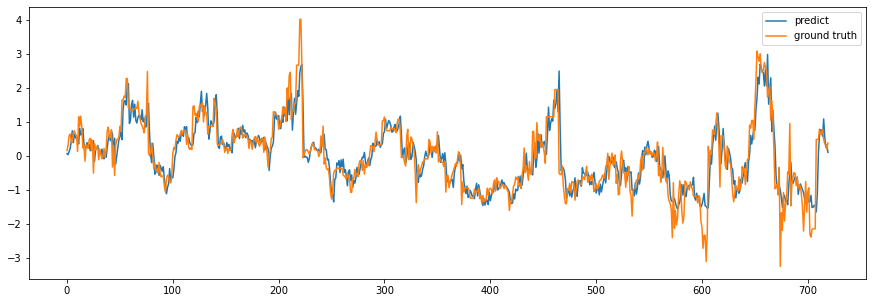

In [155]:
predict(train_dataloader, model,device)

In [165]:
model.state_dict().keys()

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l3', 'lstm.weight_hh_l3', 'lstm.bias_ih_l3', 'lstm.bias_hh_l3', 'fc.0.weight', 'fc.0.bias'])

In [225]:
sd=model.state_dict()
sd['lstm.bias_ih_l3'].to('cpu').numpy().shape

(40,)

In [28]:
import math                         # 导入模块
import random                       # 导入模块
from datetime import datetime
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=torch.load('model_LSTM1', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
# 子程序：定义优化问题的目标函数
def cal_Energy(X, nVar):
    X=X.reshape(-1,1)
    model.state_dict()['lstm.weight_ih_l0']=torch.from_numpy(X).to(device)
    h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
    loss_total =  0
    with torch.no_grad():
        for batch_idx, (X,y) in enumerate(Time_Series_Data(Spread_new[730:])):  
            X,y = X.to(device),y.to(device)
            out,(h,c) = model(X,h,c)
            loss_total+= loss_fn(out, y)
    loss_sum=loss_total.item()
    return loss_sum


# 子程序：模拟退火算法的参数设置
def ParameterSetting():
    cName = "funcOpt"           # 定义问题名称
    nVar = 40                    # 给定自变量数量，y=f(x1,..xn)
    xMin = [-1 for i in range(nVar)]         # 给定搜索空间的下限，x1_min,..xn_min
    xMax = [1.5 for i in range(nVar)]           # 给定搜索空间的上限，x1_max,..xn_max

    tInitial = 100.0            # 设定初始退火温度(initial temperature)
    tFinal  = 1                 # 设定终止退火温度(stop temperature)
    alfa    = 0.98              # 设定降温参数，T(k)=alfa*T(k-1)
    meanMarkov = 100            # Markov链长度，也即内循环运行次数
    scale   = 0.01               # 定义搜索步长，可以设为固定值或逐渐缩小
    return cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale

In [29]:
# 模拟退火算法
def OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale):
    # ====== 初始化随机数发生器 ======
    randseed = random.randint(1, 100)
    random.seed(randseed)  # 随机数发生器设置种子，也可以设为指定整数

    # ====== 随机产生优化问题的初始解 ======
    xInitial = np.zeros((nVar))   # 初始化，创建数组
    for v in range(nVar):
        # random.uniform(min,max) 在 [min,max] 范围内随机生成一个实数
        xInitial[v] = random.uniform(xMin[v], xMax[v])
    # 调用子函数 cal_Energy 计算当前解的目标函数值
    fxInitial = cal_Energy(xInitial, nVar)

    # ====== 模拟退火算法初始化 ======
    xNew = np.zeros((nVar))         # 初始化，创建数组
    xNow = np.zeros((nVar))         # 初始化，创建数组
    xBest = np.zeros((nVar))        # 初始化，创建数组
    xNow[:]  = xInitial[:]          # 初始化当前解，将初始解置为当前解
    xBest[:] = xInitial[:]          # 初始化最优解，将当前解置为最优解
    fxNow  = fxInitial              # 将初始解的目标函数置为当前值
    fxBest = fxInitial              # 将当前解的目标函数置为最优值
    print('x_Initial:{:.6f},{:.6f},\tf(x_Initial):{:.6f}'.format(xInitial[0], xInitial[1], fxInitial))

    recordIter = []                 # 初始化，外循环次数
    recordFxNow = []                # 初始化，当前解的目标函数值
    recordFxBest = []               # 初始化，最佳解的目标函数值
    recordPBad = []                 # 初始化，劣质解的接受概率
    kIter = 0                       # 外循环迭代次数，温度状态数
    totalMar = 0                    # 总计 Markov 链长度
    totalImprove = 0                # fxBest 改善次数
    nMarkov = meanMarkov            # 固定长度 Markov链

    # ====== 开始模拟退火优化 ======
    # 外循环，直到当前温度达到终止温度时结束
    tNow = tInitial                 # 初始化当前温度(current temperature)
    while tNow >= tFinal:           # 外循环，直到当前温度达到终止温度时结束
        # 在当前温度下，进行充分次数(nMarkov)的状态转移以达到热平衡
        kBetter = 0                 # 获得优质解的次数
        kBadAccept = 0              # 接受劣质解的次数
        kBadRefuse = 0              # 拒绝劣质解的次数

        # ---内循环，循环次数为Markov链长度
        for k in range(nMarkov):    # 内循环，循环次数为Markov链长度
            totalMar += 1           # 总 Markov链长度计数器

            # ---产生新解
            # 产生新解：通过在当前解附近随机扰动而产生新解，新解必须在 [min,max] 范围内
            # 方案 1：只对 n元变量中的一个进行扰动，其它 n-1个变量保持不变
            xNew[:] = xNow[:]
            v = random.randint(0, nVar-1)   # 产生 [0,nVar-1]之间的随机数
            xNew[v] = xNow[v] + scale * (xMax[v]-xMin[v]) * random.normalvariate(0, 1)
            # random.normalvariate(0, 1)：产生服从均值为0、标准差为 1 的正态分布随机实数
            xNew[v] = max(min(xNew[v], xMax[v]), xMin[v])  # 保证新解在 [min,max] 范围内

            # ---计算目标函数和能量差
            # 调用子函数 cal_Energy 计算新解的目标函数值
            fxNew = cal_Energy(xNew, nVar)
            deltaE = fxNew - fxNow

            # ---按 Metropolis 准则接受新解
            # 接受判别：按照 Metropolis 准则决定是否接受新解
            if fxNew < fxNow:  # 更优解：如果新解的目标函数好于当前解，则接受新解
                accept = True
                kBetter += 1
            else:  # 容忍解：如果新解的目标函数比当前解差，则以一定概率接受新解
                pAccept = math.exp(-deltaE / tNow)  # 计算容忍解的状态迁移概率
                if pAccept > random.random():
                    accept = True  # 接受劣质解
                    kBadAccept += 1
                else:
                    accept = False  # 拒绝劣质解
                    kBadRefuse += 1

            # 保存新解
            if accept == True:  # 如果接受新解，则将新解保存为当前解
                xNow[:] = xNew[:]
                fxNow = fxNew
                if fxNew < fxBest:  # 如果新解的目标函数好于最优解，则将新解保存为最优解
                    fxBest = fxNew
                    xBest[:] = xNew[:]
                    totalImprove += 1
                    scale = scale*0.99  # 可变搜索步长，逐步减小搜索范围，提高搜索精度
                    
        # ---内循环结束后的数据整理
        # 完成当前温度的搜索，保存数据和输出
        pBadAccept = kBadAccept / (kBadAccept + kBadRefuse)  # 劣质解的接受概率
        recordIter.append(kIter)  # 当前外循环次数
        recordFxNow.append(round(fxNow, 4))  # 当前解的目标函数值
        recordFxBest.append(round(fxBest, 4))  # 最佳解的目标函数值
        recordPBad.append(round(pBadAccept, 4))  # 最佳解的目标函数值

        if kIter%10 == 0:                           # 模运算，商的余数
            print('i:{},t(i):{:.2f}, badAccept:{:.6f}, f(x)_best:{:.6f}'.\
                format(kIter, tNow, pBadAccept, fxBest))

        # 缓慢降温至新的温度，降温曲线：T(k)=alfa*T(k-1)
        tNow = tNow * alfa
        kIter = kIter + 1
        # ====== 结束模拟退火过程 ======

    print('improve:{:d}'.format(totalImprove))
    return kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad


In [213]:
# 结果校验与输出
def ResultOutput(cName,nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter):
    # ====== 优化结果校验与输出 ======
    fxCheck = cal_Energy(xBest,nVar)
    if abs(fxBest - fxCheck)>1e-3:   # 检验目标函数
        print("Error 2: Wrong total millage!")
        return
    else:
        print("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            print('\tx[{}] = {:.6f}'.format(i,xBest[i]))
        print('\n\tf(x):{:.6f}'.format(fxBest))
    return

# 主程序
# def main():
# 参数设置，优化问题参数定义，模拟退火算法参数设置
[cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale] = ParameterSetting()
# 模拟退火算法
[kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad] \
    = OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale)

# 结果校验与输出
ResultOutput(cName, nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter)

x_Initial:-0.391206,0.255522,	f(x_Initial):12.077118
i:0,t(i):100.00, badAccept:1.000000, f(x)_best:9.090268
i:10,t(i):81.71, badAccept:0.982143, f(x)_best:8.085929
i:20,t(i):66.76, badAccept:1.000000, f(x)_best:8.085929
i:30,t(i):54.55, badAccept:0.956522, f(x)_best:8.085929
i:40,t(i):44.57, badAccept:0.962264, f(x)_best:7.677394
i:50,t(i):36.42, badAccept:0.894737, f(x)_best:7.677394
i:60,t(i):29.76, badAccept:0.981481, f(x)_best:7.677394
i:70,t(i):24.31, badAccept:0.944444, f(x)_best:7.677394
i:80,t(i):19.86, badAccept:0.963636, f(x)_best:7.677394
i:90,t(i):16.23, badAccept:0.857143, f(x)_best:7.677394
i:100,t(i):13.26, badAccept:0.960000, f(x)_best:7.677394
i:110,t(i):10.84, badAccept:0.882353, f(x)_best:7.677394
i:120,t(i):8.85, badAccept:0.890909, f(x)_best:7.677394
i:130,t(i):7.23, badAccept:0.736842, f(x)_best:7.677394
i:140,t(i):5.91, badAccept:0.900000, f(x)_best:7.677394
i:150,t(i):4.83, badAccept:0.830508, f(x)_best:7.677394
i:160,t(i):3.95, badAccept:0.800000, f(x)_best:7.

In [214]:
torch.save(model,'model_LSTM1_afterSA')

In [397]:
predict(Time_Series_Data(Spread_new[730:]), model,device)

C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\solit\anaconda3\envs\LSTM_CNN\lib\site-packages\num

In [40]:
model=torch.load('model_LSTM1')
time=np.linspace(1,789,789)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
outs_train,outs_test = [],[]
with torch.no_grad():
    for batch_idx, (X,y) in enumerate(Time_Series_Data(Spread_new[:730])):  
        X,y = X.to(device),y.to(device)
        out,(h,c) = model(X,h,c)
        outs_train.append(out.to('cpu').item())
    for batch_idx, (X,y) in enumerate(Time_Series_Data(Spread_new[730:])):  
        X,y = X.to(device),y.to(device)
        out,(h,c) = model(X,h,c)
        outs_test.append(out.to('cpu').item())
mean_spread=Spread_2D.mean()
sigma_spread=Spread_2D.std()
# print("mean_spread={}\n".format(mean_spread))
# print("sigma_spread={}".format(sigma_spread))
outs_train_new=[outs_train[i]*sigma_spread+mean_spread for i in range(len(outs_train))]
outs_test_new=[outs_test[i]*sigma_spread+mean_spread for i in range(len(outs_test))] 
outs_test_new_x=[]
for i in range(1,len(outs_test_new)):
    outs_test_new_x.append(outs_test_new[i-1])
outs_test_new_x.append(750)
plt.rcParams['figure.figsize'] = [15,5]
mpl.rcParams['figure.dpi']=1200
plt.plot(np.arange(len(outs_test_new_x)),Spread_arr[740:],color='indianred',linestyle='-',label='spread')
plt.plot(np.arange(len(outs_test_new_x)),outs_test_new_x,\
                     #linestyle='-.',
                     color='mediumseagreen',\
                     label = 'pre_spread_test')

# plt.plot(np.arange(len(rb_arr)),hc_arr,color='indianred',label='hc')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks([0,10,20,30,40,50],['2022-01-04','2022-01-18','2022-02-07','2022-02-24','2022-03-14','2022-04-01'])
plt.legend()

In [44]:
(13.799421/49)*sigma_spread+mean_spread

728.2958349444763

In [75]:
model=torch.load('model_LSTM1_afterSA',map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
time=np.linspace(1,789,789)
h = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
c = torch.zeros(1*model.num_layers,model.hidden_size).float().to(device)
outs_train,outs_test = [],[]
with torch.no_grad():
    for batch_idx, (X,y) in enumerate(Time_Series_Data(Spread_new[:730])):  
        X,y = X.to(device),y.to(device)
        out,(h,c) = model(X,h,c)
        outs_train.append(out.to('cpu').item())
    for batch_idx, (X,y) in enumerate(Time_Series_Data(Spread_new[730:])):  
        X,y = X.to(device),y.to(device)
        out,(h,c) = model(X,h,c)
        outs_test.append(out.to('cpu').item())
mean_spread=Spread_2D.mean()
sigma_spread=Spread_2D.std()
# print("mean_spread={}\n".format(mean_spread))
# print("sigma_spread={}".format(sigma_spread))
outs_train_new=[outs_train[i]*sigma_spread+mean_spread for i in range(len(outs_train))]
outs_test_new=[outs_test[i]*sigma_spread+mean_spread for i in range(len(outs_test))] 
plt.rcParams['figure.figsize'] = [20,5]
mpl.rcParams['figure.dpi']=1200
plt.plot(time,Spread_arr,color='indianred',linestyle='-',label='spread')
plt.plot(np.arange(predict_intake_len,predict_intake_len+len(outs_train_new)),outs_train_new,\
         #linestyle='-.',\
         color='royalblue',\
         label = 'pre_spread_train')
plt.plot(np.arange(predict_intake_len*2+len(outs_train_new),\
                   predict_intake_len*2+len(outs_train_new)+len(outs_test_new)),outs_test_new,\
                     #linestyle='-.',
                     color='mediumseagreen',\
                     label = 'pre_spread_test')

# plt.plot(np.arange(len(rb_arr)),hc_arr,color='indianred',label='hc')
plt.xlabel('Time')
plt.ylabel('Price')
#plt.xticks([0,100,200,300,400,500,600,700,800],['2019-01-02','2019-06-03','2019-10-30','2020-03-27','2020-08-24','2021-01-20','2021-06-23','2021-11-19','2022-04-01'])
plt.legend()

In [79]:
r2_score(outs_test_new,Spread__arr[740:])

-2.0431869103039157

## Test

In [468]:
# # plt.plot(np.arange(550+predict_intake_len,predict_intake_len+len(outs_train_new)),outs_train_new[550:],label = 'predict')
# # plt.plot(np.arange(550+predict_intake_len,predict_intake_len+len(outs_train_new)),Spread_invest_arr[560:730],label = 'base1')
# # #plt.plot(np.arange(550+predict_intake_len,predict_intake_len+len(outs_train_new)),Spread_arr[560:730],label = 'base2')
# # plt.legend()

# time=np.linspace(2,789,788)
# plt.rcParams['figure.figsize'] = [30,5]
# mpl.rcParams['figure.dpi']=1200
# plt.plot(time,delta_spread,color='indianred',linestyle='-',label='delta_spread')
# plt.plot(np.arange(1+predict_intake_len,1+predict_intake_len+len(delta_pre_spread)),delta_pre_spread,\
#          #linestyle='-.',\
#          color='royalblue',\
#          label = 'delta_pre_spread_train')
# plt.plot(np.arange(predict_intake_len*2+len(delta_pre_spread)+2,\
#                    predict_intake_len*2+len(delta_pre_spread)+2+len(delta_pre_spread_test)),\
#                      delta_pre_spread_test,\
#                      #linestyle='-.',
#                      color='mediumseagreen',\
#                      label = 'delta_pre_spread_test')

# # plt.plot(np.arange(len(rb_arr)),hc_arr,color='indianred',label='hc')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.xticks([0,100,200,300,400,500,600,700,800],['2019-01-03','2019-06-03','2019-10-30','2020-03-27','2020-08-24','2021-01-20','2021-06-23','2021-11-19','2022-04-01'])
# plt.legend()

In [58]:
# plt.plot(np.arange(550+predict_intake_len,predict_intake_len+len(outs_train_new)),outs_train_new[550:],label = 'train')
# plt.plot(np.arange(550+predict_intake_len,predict_intake_len+len(outs_train_new)),Spread_arr[560:730],label = 'test')
# plt.legend()

loss_fn = nn.L1Loss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=torch.load('model_LSTM1', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

dataloader=Time_Series_Data(Spread_new[:730])
test_loop(dataloader, model, loss_fn, device)
dataloader=Time_Series_Data(Spread_new[730:])
test_loop(dataloader, model, loss_fn, device)

Spread_invest=[Spread_arr[0]]
for i in range(1,len(Spread_arr)):
    Spread_invest.append(Spread_arr[i-1])
print("Spread_invest:{}".format(len(Spread_invest)))
Spread_invest_arr=np.array(Spread_invest)
Spread_invest_2D=Spread_invest_arr.reshape(-1,1)
scaler = StandardScaler().fit(Spread_invest_2D[:730])
Spread_invest_new=scaler.transform(Spread_invest_2D)
print('After processing---------------------------------------')
dataloader=Time_Series_Data(Spread_invest_new[:730])
test_loop(dataloader, model, loss_fn, device)
dataloader=Time_Series_Data(Spread_invest_new[730:])
test_loop(dataloader, model, loss_fn, device)
#

Test loss: -inf
Test loss: -inf
Spread_invest:789
After processing---------------------------------------
Test loss: -inf
Test loss: -inf


In [56]:
(13.799421/59)*sigma_spread+mean_spread

719.9610803277875

In [462]:
Fee=2/10000*(data['rb']+Beta*data['hc'])
Fee_arr=np.array(Fee)
print("Fee_arr:{}".format(len(Fee_arr)))
sum_ten=0
for i in range(predict_intake_len):
    sum_ten+=Fee_arr[i]
Fee_sum=[sum_ten]
for i in range(predict_intake_len+1,789):
    Fee_sum.append(sum_ten + Fee_arr[i-1]-Fee_arr[i-11])
print("Fee_sum:789-{}={}".format(predict_intake_len,len(Fee_sum)))
delta_spread=[(Spread_arr[i]-Spread_arr[i-1]) for i in range(1,len(Spread_arr))]
delta_pre_spread=[(outs_train_new[i]-outs_train_new[i-1]) for i in range(1,len(outs_train_new))]
delta_pre_spread_test=[(outs_test_new[i]-outs_test_new[i-1]) for i in range(1,len(outs_test_new))]
print("delta_spread:730-{}-1={}".format(predict_intake_len,len(delta_spread)))
print("delta_pre_spread:730-{}-1={}".format(predict_intake_len,len(delta_pre_spread)))
print("delta_pre_spread_test:789-730-{}-1={}".format(predict_intake_len,len(delta_pre_spread_test)))
print("Spread_arr:{}".format(len(Spread_arr)))


Fee_arr:789
Fee_sum:789-10=779
delta_spread:730-10-1=788
delta_pre_spread:730-10-1=719
delta_pre_spread_test:789-730-10-1=48
Spread_arr:789


## A_train

In [510]:
low_level=mean_spread-2*sigma_spread
Spread_record,Fee_record=[],[]
Earns=[]
for i in range(predict_intake_len+1,730):
    if delta_pre_spread[i-(predict_intake_len+1)]>0.3*Fee_sum[i-(predict_intake_len)] and \
        Spread_invest_arr[i-1]<low_level: #and len(Spread_record)==0:
        Spread_record.append(Spread_invest_arr[i-1])
        Fee_record.append(Fee_arr[i-1])
        #print("LowPt:{}".format(i-1))
    if delta_pre_spread[i-(predict_intake_len+1)]<0 :
        while len(Spread_record)>0:
            LowPt=Spread_record.pop()
            pre_Fee=Fee_record.pop()
            HighPt=Spread_invest_arr[i-1]
            #print("HighPt:{}".format(i-1))
            now_Fee=Fee_arr[i-1]
            earn=10*((HighPt-LowPt)-(pre_Fee+now_Fee))
            Earns.append(earn)
Earn_total=0
earn_yes=0
for item in Earns:
    if item>0:earn_yes+=1
    Earn_total+=item
print("Earns_len={}".format(len(Earns)))
print("earn_yes={}".format(earn_yes))
print("Earn_total={}".format(Earn_total))

Earns_len=9
earn_yes=8
Earn_total=25796.98561312825


## B train

In [511]:
high_level=mean_spread+2*sigma_spread
Spread_record,Fee_record=[],[]
Earns=[]
for i in range(predict_intake_len+1,730):
    if delta_pre_spread[i-(predict_intake_len+1)]<(-0.3)*Fee_sum[i-(predict_intake_len)] and \
        Spread_invest_arr[i-1]>high_level:# and len(Spread_record)==0:
        Spread_record.append(Spread_invest_arr[i-1])
        Fee_record.append(Fee_arr[i-1])
        #print("LowPt:{}".format(i-1))
    if delta_pre_spread[i-(predict_intake_len+1)]>0:
        while len(Spread_record)>0:
            HighPt=Spread_record.pop()
            pre_Fee=Fee_record.pop()
            LowPt=Spread_invest_arr[i-1]
            #print("HighPt:{}".format(i-1))
            now_Fee=Fee_arr[i-1]
            earn=10*((HighPt-LowPt)-(pre_Fee+now_Fee))
            Earns.append(earn)
Earn_total=0
earn_yes=0
for item in Earns:
    if item>0:earn_yes+=1
    Earn_total+=item
print("Earns_len={}".format(len(Earns)))
print("earn_yes={}".format(earn_yes))
print("Earn_total={}".format(Earn_total))

Earns_len=14
earn_yes=10
Earn_total=33669.40639431108


In [513]:
(25796.98561312825+33669.40639431108)/23

2585.4953046712753

## A_test

In [514]:
low_level=mean_spread-1*sigma_spread
Spread_record,Fee_record=[],[]
Earns=[]
for i in range(730+predict_intake_len+1,789):
    if delta_pre_spread_test[i-(730+predict_intake_len+1)]>0.3*Fee_sum[i-(730+predict_intake_len)] and \
        Spread_invest_arr[i-1]<low_level:# and len(Spread_record)==0:
        Spread_record.append(Spread_invest_arr[i-1])
        Fee_record.append(Fee_arr[i-1])
        print("LowPt:{}".format(i-1))
    if delta_pre_spread_test[i-(730+predict_intake_len+1)]<0 and len(Spread_record)>0:
        while len(Spread_record)>0:
            LowPt=Spread_record.pop()
            pre_Fee=Fee_record.pop()
            HighPt=Spread_invest_arr[i-1]
            print("HighPt:{}".format(i-1))
            now_Fee=Fee_arr[i-1]
            earn=10*((HighPt-LowPt)-(pre_Fee+now_Fee))
            Earns.append(earn)
Earn_total=0
earn_yes=0
for item in Earns:
    if item>0:earn_yes+=1
    Earn_total+=item
print("Earns_len={}".format(len(Earns)))
print("earn_yes={}".format(earn_yes))
print("Earn_total={}".format(Earn_total))

Earn_total=0


## B_test

In [518]:
high_level=mean_spread+2*sigma_spread
Spread_record,Fee_record=[],[]
Earns=[]
for i in range(730+predict_intake_len+1,789):
    if delta_pre_spread_test[i-(730+predict_intake_len+1)]<(-0.3)*Fee_sum[i-(730+predict_intake_len)] and \
        Spread_invest_arr[i-1]>high_level:# and len(Spread_record)==0:
        Spread_record.append(Spread_invest_arr[i-1])
        Fee_record.append(Fee_arr[i-1])
        print("LowPt:{}".format(i-1))
    if delta_pre_spread_test[i-(730+predict_intake_len+1)]>0 and len(Spread_record)>0:
        while len(Spread_record)>0:
            HighPt=Spread_record.pop()
            pre_Fee=Fee_record.pop()
            LowPt=Spread_invest_arr[i-1]
            print("HighPt:{}".format(i-1))
            now_Fee=Fee_arr[i-1]
            earn=10*((HighPt-LowPt)-(pre_Fee+now_Fee))
            Earns.append(earn)
Earn_total=0
earn_yes=0
for item in Earns:
    if item>0:earn_yes+=1
    Earn_total+=item
print("Earns_len={}".format(len(Earns)))
print("earn_yes={}".format(earn_yes))
print("Earn_total={}".format(Earn_total))

LowPt:749
HighPt:751
Earns_len=1
earn_yes=1
Earn_total=3595.051187075991


In [ ]:
def training_loop(n_epochs, optimiser, model, loss_fn, X_train,  X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        #output_train = model(X_train) # forwards pass
        output_train = model.predict(X_train,batch_size=1)#预测未来一个值
        loss_train = loss_fn(output_train, y_train) # calculate loss
        #output_val = model(X_val) 
        output_val = model.predict(X_val,batch_size=1)
        loss_val = loss_fn(output_val, y_val)
        
        optimiser.zero_grad() # set gradients to zero
        loss_train.backward() # backwards pass
        optimiser.step() # update model parameters
        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
optimiser = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs = 5000, 
    optimiser = optimiser,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    X_train = X_train,
    X_val = X_val, 
    y_train = y_train,
    y_val = y_val)

In [ ]:
# online forecast
for i in range(len(X)):
    testX, testy = X[i], y[i]
    testX = testX.reshape(1, 1, 1)
    yhat = model.predict(testX, batch_size=1)
    print('>Expected=%.1f, Predicted=%.1f' % (testy, yhat))

In [ ]:
# RNNs模型基类，主要是用于指定参数和cell类型
class BaseModel(nn.Module):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda=False):

        super(BaseModel, self).__init__()
        self.hiddenNum = hiddenNum
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.layerNum = layerNum
        self.use_cuda = use_cuda
        if cell == "RNN":
            self.cell = nn.RNN(input_size=self.inputDim, hidden_size=self.hiddenNum,
                        num_layers=self.layerNum, dropout=0.0,
                         nonlinearity="tanh", batch_first=True,)
        if cell == "LSTM":
            self.cell = nn.LSTM(input_size=self.inputDim, hidden_size=self.hiddenNum,
                               num_layers=self.layerNum, dropout=0.0,
                               batch_first=True, )
        if cell == "GRU":
            self.cell = nn.GRU(input_size=self.inputDim, hidden_size=self.hiddenNum,
                                num_layers=self.layerNum, dropout=0.0,
                                 batch_first=True, )
        print(self.cell)
        self.fc = nn.Linear(self.hiddenNum, self.outputDim)
# LSTM模型
class LSTMModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda):
        super(LSTMModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda)

    def forward(self, x):

        batchSize = x.size(0)
        h0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        c0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        if self.use_cuda:
            h0 = h0.cuda()
            c0 = c0.cuda()
        rnnOutput, hn = self.cell(x, (h0, c0))
        hn = hn[0].view(batchSize, self.hiddenNum)
        fcOutput = self.fc(hn)

        return fcOutput
